# Damped Sine Wave Prediction Problem

- 減衰するサイン波の時系列データを予測する問題
- LSTMを積み上げて多層化するStacked LSTMで解く
- 多層パーセプトロンのように層を積み上げて入力特徴量を変換していくように、LSTM層を積み上げて時系列データを変換していく
- 多層パーセプトロンで層を深くすると表現力が上がるように、LSTMを多数積み上げたモデルも表現力が上がる
- デフォルトのLSTMでは系列の要素を全て入力し終わった後の最後の隠れ状態のみ出力していた
- 多層LSTMでは、下の層のLSTMは系列の各要素を入れた時の隠れ状態を全て出力するように実装する

## Keras version

In [162]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
import random
%matplotlib inline

In [163]:
# (timesteps, input_dim)
# 長さ3で特徴量の次元数が1の系列データを入力（ミニバッチサイズは省略）
model = Sequential()
model.add(LSTM(1, input_shape=(3, 1)))
model.compile(optimizer='adam', loss='mse')

# (nb_samples, timesteps, input_dim)の3Dテンソルに変換
data = np.array([0.1, 0.2, 0.3]).reshape((1, 3, 1))

# (nb_samples, output_dim)
result = model.predict(data)

print(result.shape)

(1, 1)


- KerasのデフォルトのLSTMの出力は、(batch_size, units)
- 入力系列の各要素に対する出力は出さない（最後の出力のみ）
- return_sequences=TrueとするとLSTMの出力は、(batch_size, timesteps, units)
- 入力系列の各要素に対する出力を出す
- Stacked LSTMの下の層は入力系列の各要素に対する出力を出す必要がある

In [164]:
model = Sequential()
model.add(LSTM(1, return_sequences=True, input_shape=(3, 1)))
model.compile(optimizer='adam', loss='mse')
data = np.array([0.1, 0.2, 0.3]).reshape((1, 3, 1))
result = model.predict(data)
print(result.shape)

(1, 3, 1)


Stacked LSTMを実装するときは

```
model = Sequential()
model.add(LSTM(..., return_sequences=True, input_shape=(...)))
model.add(LSTM(..., return_sequences=True, input_shape=(...)))
model.add(LSTM(..., return_sequences=True, input_shape=(...)))
model.add(LSTM(...))
model.add(Dense(...))
```

のようになる。上の例ではLSZTMを4層積み上げた例。下の層のLSTMは系列の各要素に対する出力を出して次のLSTMへの入力とする

## Damped Sine Wave Prediction Problem

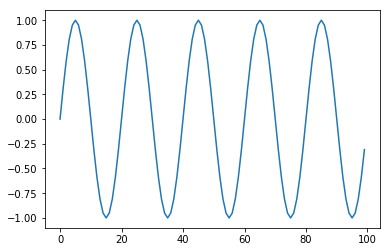

In [165]:
import math
import matplotlib.pyplot as plt

length = 100
freq = 5
sequence = [math.sin(2 * math.pi * freq * (i / length)) for i in range(length)]

plt.plot(sequence)
plt.show()

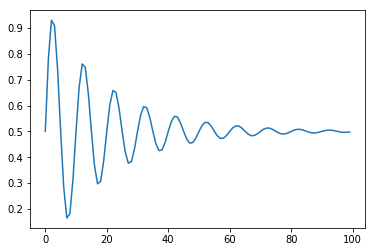

In [166]:
length = 100
period = 10
decay = 0.05
sequence = [0.5 + 0.5 * math.sin(2 * math.pi * i / period) * math.exp(-decay * i) for i in range(length)]
plt.plot(sequence)
plt.show()

In [167]:
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * math.sin(2 * math.pi * i / period) * math.exp(-decay * i) for i in range(length)]

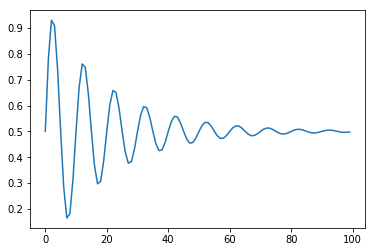

In [229]:
sequence = generate_sequence(100, 10, 0.05)
plt.plot(sequence)
plt.show()

In [168]:
# periodとdecayはランダムな系列を生成する
# 長さがlengthでテスト用に長さがoutputの系列を付け加える
def generate_examples(length, n_patterns, output):
    X, y = list(), list()
    for _ in range(n_patterns):
        p = random.randint(10, 20)
        d = random.uniform(0.01, 0.1)
        sequence = generate_sequence(length + output, p, d)
        X.append(sequence[:-output])
        y.append(sequence[-output:])
    # input: (nb_samples, timesteps, input_dim)
    X = np.array(X).reshape(n_patterns, length, 1)
    # output: (nb_samples, output_dim)
    y = np.array(y).reshape(n_patterns, output)
    return X, y

In [169]:
# 長さが50の系列を5個生成する、テスト用に継続する5の系列も作成
X, y = generate_examples(50, 5, 5)
print(X.shape, y.shape)

(5, 50, 1) (5, 5)


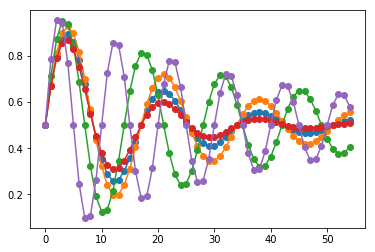

In [170]:
for i in range(len(X)):
    plt.plot([x for x in X[i, :, 0]] + [x for x in y[i]], '-o')

- many-to-one として実装するのがポイント
- 長さnの系列を出力するのではなく、長さが1でn次元の特徴をもつ系列を予測する
- （例）長さが50で1次元の系列を入力して、長さが1で5次元の特徴量を出力する（この5次元は系列とみなす）
- 1次元の特徴量で長さnの系列を出力するアーキテクチャにすることもできる

In [171]:
length = 50
output = 5

model = Sequential()
model.add(LSTM(20, return_sequences=True, input_shape=(length, 1)))
model.add(LSTM(20))
model.add(Dense(output))
model.compile(loss='mae', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 20)            1760      
_________________________________________________________________
lstm_10 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 105       
Total params: 5,145
Trainable params: 5,145
Non-trainable params: 0
_________________________________________________________________


In [172]:
X, y = generate_examples(length, 10000, output)
model.fit(X, y, batch_size=10, epochs=1)

Epoch 1/1
10000/10000 [==============================] - 70s 7ms/step - loss: 0.0487


In [173]:
X, y = generate_examples(length, 1000, output)
loss = model.evaluate(X, y, verbose=0)
print('MAE: %f' % loss)

MAE: 0.022444


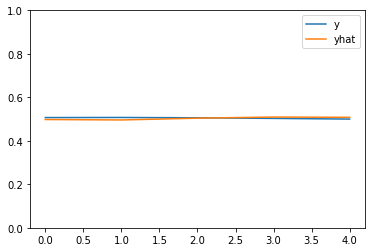

In [175]:
X, y = generate_examples(length, 1, output)
yhat = model.predict(X, verbose=0)
plt.plot(y[0], label='y')
plt.plot(yhat[0], label='yhat')
plt.ylim((0.0, 1.0))
plt.legend()
plt.show()

## PyTorch version

In [194]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [195]:
cuda = torch.cuda.is_available()
if cuda:
    print('cuda available')
device = torch.device('cuda' if cuda else 'cpu')

In [196]:
def generate_sequence(length, period, decay):
    return [0.5 + 0.5 * math.sin(2 * math.pi * i / period) * math.exp(-decay * i) for i in range(length)]

def generate_examples(length, n_patterns, output):
    X, y = list(), list()
    for _ in range(n_patterns):
        p = random.randint(10, 20)
        d = random.uniform(0.01, 0.1)
        sequence = generate_sequence(length + output, p, d)
        X.append(sequence[:-output])
        y.append(sequence[-output:])

    # numpy to tensor
    # regressionタスクなので入力・出力ともにfloat
    X = torch.from_numpy(np.array(X)).float()
    y = torch.from_numpy(np.array(y)).float()

    # input: (seq_len, batch, input_size)
    X = X.view(length, n_patterns, 1)

    # output: (batch, seq_len)
    y = y.view(n_patterns, output)

    return X, y

In [197]:
X, y = generate_examples(50, 16, 5)
print(X.size(), y.size())

torch.Size([50, 16, 1]) torch.Size([16, 5])


- PyTorchの場合、LSTMは複数レイヤに対応している
- 引数のnum_layersを指定するだけでOK

> num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1

- 隠れ状態（cとh）は層の分だけサイズを確保する必要がある

In [198]:
length = 50
n_features = 1
hidden_size = 20
num_layers = 2
output_size = 5
batch_size = 10
    
class DampedSineWavePredictionModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DampedSineWavePredictionModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, h, c):
        output, (h, c) = self.lstm(input, (h, c))
        output = self.out(output)
        return output, (h, c)

In [199]:
model = DampedSineWavePredictionModel(n_features, hidden_size, num_layers, output_size)

In [200]:
model

DampedSineWavePredictionModel(
  (lstm): LSTM(1, 20, num_layers=2)
  (out): Linear(in_features=20, out_features=5, bias=True)
)

In [201]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

for i in range(1000):
    # ミニバッチの系列データを生成
    X, y = generate_examples(length, batch_size, output_size)

    # ミニバッチ系列を入力してパラメータを更新したら勾配はリセット
    model.zero_grad()
    
    # 新しいミニバッチを入れるたびに隠れ状態はリセット
    h0 = torch.zeros(num_layers, batch_size, hidden_size)
    c0 = torch.zeros(num_layers, batch_size, hidden_size)

    output, (h, c) = model(X, h0, c0)
    
    loss = criterion(output[-1], y)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

In [202]:
len(losses)

1000

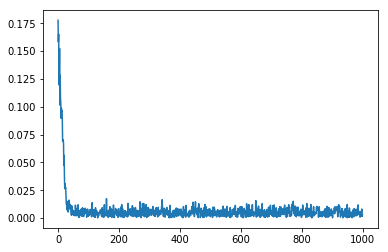

In [203]:
plt.plot(losses)

In [204]:
# 予測
X, y = generate_examples(length, 1, output_size)
h0 = torch.zeros(num_layers, 1, hidden_size)
c0 = torch.zeros(num_layers, 1, hidden_size)
yhat, (h, c) = model(X, h0, c0)

In [205]:
y.size()

torch.Size([1, 5])

In [206]:
yhat.size()

torch.Size([50, 1, 5])

In [207]:
yhat[-1].size()

torch.Size([1, 5])

In [208]:
import torch.nn.functional as F
F.mse_loss(y, yhat[-1])

tensor(1.00000e-04 *
       5.1041)

In [209]:
y

tensor([[ 0.5000,  0.4816,  0.4665,  0.4557,  0.4501]])

In [210]:
yhat[-1]

tensor([[ 0.4851,  0.4807,  0.4850,  0.4851,  0.4836]])

(0.0, 1.0)

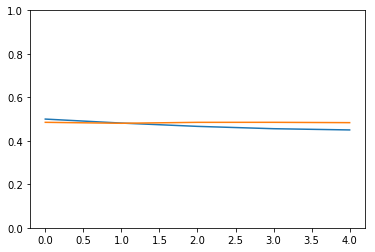

In [211]:
plt.plot(y[0].numpy())
plt.plot(yhat[-1][0].detach().numpy())
plt.ylim((0.0, 1.0))

## 層を積み重ねると表現力上がるのか？

In [218]:
def train(num_layers):
    model = DampedSineWavePredictionModel(n_features, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []

    for i in range(1000):
        # ミニバッチの系列データを生成
        X, y = generate_examples(length, batch_size, output_size)

        # ミニバッチ系列を入力してパラメータを更新したら勾配はリセット
        model.zero_grad()

        # 新しいミニバッチを入れるたびに隠れ状態はリセット
        h0 = torch.zeros(num_layers, batch_size, hidden_size)
        c0 = torch.zeros(num_layers, batch_size, hidden_size)

        output, (h, c) = model(X, h0, c0)

        loss = criterion(output[-1], y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    
    return losses

In [227]:
losses1 = train(1)
losses2 = train(2)
losses3 = train(3)

(0.0, 0.05)

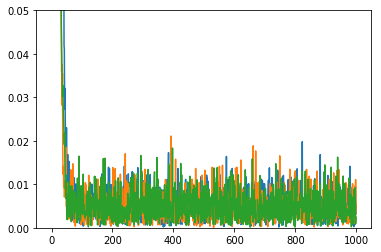

In [228]:
plt.plot(losses1)
plt.plot(losses2)
plt.plot(losses3)
plt.ylim(0.0, 0.05)